In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
DATA_PATH = "/content/drive/MyDrive/782_project"
DATA_PATH


'/content/drive/MyDrive/782_project'

In [3]:
import os
os.listdir(DATA_PATH)


['demographic.csv',
 'examination.csv',
 'medications.csv',
 'questionnaire.csv',
 'labs.csv',
 'artifacts_fast']

In [4]:
import pandas as pd

demo = pd.read_csv(f"{DATA_PATH}/demographic.csv")
exam = pd.read_csv(f"{DATA_PATH}/examination.csv")
labs = pd.read_csv(f"{DATA_PATH}/labs.csv")
med  = pd.read_csv(f"{DATA_PATH}/medications.csv", encoding="latin1")
ques = pd.read_csv(f"{DATA_PATH}/questionnaire.csv")

print("Loaded shapes:")
print(demo.shape, exam.shape, labs.shape, med.shape, ques.shape)


Loaded shapes:
(10175, 47) (9813, 224) (9813, 424) (20194, 13) (10175, 953)


In [23]:
import os, time, joblib, json
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif
from sklearn.exceptions import ConvergenceWarning
import warnings

In [49]:
DATA_PATH = "/content/drive/MyDrive/782_project"
SAMPLE_FRAC = 0.4
N_SPLITS = 3
RANDOM_SEED = 42

USE_FULL_DATA = False
SEL_METHOD = "l1_topk"
TOP_K = 100
L1_C = 0.5
EN_C = 0.7
EN_L1_RATIO = 0.4
MLP_HYBRID_ARCH = (128, 64)
MLP_FULL_ARCH = (128, 64)
SAVE_DIR = os.path.join(DATA_PATH, "artifacts_fast_hybrid")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
np.random.seed(RANDOM_SEED)

print("Loading CSVs from:", DATA_PATH)
demo = pd.read_csv(os.path.join(DATA_PATH, "demographic.csv")).head(5000)
exam = pd.read_csv(os.path.join(DATA_PATH, "examination.csv")).head(5000)
labs = pd.read_csv(os.path.join(DATA_PATH, "labs.csv")).head(5000)
med  = pd.read_csv(os.path.join(DATA_PATH, "medications.csv"), encoding='latin1').head(5000)
ques = pd.read_csv(os.path.join(DATA_PATH, "questionnaire.csv")).head(5000)
df = demo.merge(exam, on="SEQN", how="inner") \
         .merge(labs, on="SEQN", how="inner") \
         .merge(med, on="SEQN", how="inner") \
         .merge(ques, on="SEQN", how="inner")

print("Merged shape (head-limited):", df.shape)

Loading CSVs from: /content/drive/MyDrive/782_project
Merged shape (head-limited): (4863, 1657)


In [50]:
PDF_PATH = "/mnt/data/782.pdf"
os.makedirs(SAVE_DIR, exist_ok=True)
print("PDF reference:", PDF_PATH)
print("Artifacts will be saved to:", SAVE_DIR)
print("Selection method:", SEL_METHOD, "TOP_K:", TOP_K)

PDF reference: /mnt/data/782.pdf
Artifacts will be saved to: /content/drive/MyDrive/782_project/artifacts_fast_hybrid
Selection method: l1_topk TOP_K: 100


In [27]:
df = df[df["DIQ010"].isin([1,2])].copy()
df["diabetes"] = df["DIQ010"].apply(lambda x: 1 if x==1 else 0)
df = df.drop(columns=["DIQ010","SEQN"], errors="ignore")

In [28]:
if USE_FULL_DATA:
    demo = pd.read_csv(os.path.join(DATA_PATH, "demographic.csv"))
    exam = pd.read_csv(os.path.join(DATA_PATH, "examination.csv"))
    labs = pd.read_csv(os.path.join(DATA_PATH, "labs.csv"))
    med  = pd.read_csv(os.path.join(DATA_PATH, "medications.csv"), encoding='latin1')
    ques = pd.read_csv(os.path.join(DATA_PATH, "questionnaire.csv"))
    df = demo.merge(exam, on="SEQN", how="inner") \
             .merge(labs, on="SEQN", how="inner") \
             .merge(med, on="SEQN", how="inner") \
             .merge(ques, on="SEQN", how="inner")
    df = df[df["DIQ010"].isin([1,2])].copy()
    df["diabetes"] = df["DIQ010"].apply(lambda x: 1 if x==1 else 0)
    df = df.drop(columns=["DIQ010","SEQN"], errors="ignore")
    print("Using full data. New merged shape:", df.shape)

In [29]:
if SAMPLE_FRAC < 1.0:
    df = df.sample(frac=SAMPLE_FRAC, random_state=RANDOM_SEED).reset_index(drop=True)
    print(f"Sampled fraction {SAMPLE_FRAC}. New shape: {df.shape}")

Sampled fraction 0.4. New shape: (1835, 1656)


In [30]:
miss_thresh = 0.5
drop_cols = df.columns[df.isnull().mean() > miss_thresh].tolist()
if drop_cols:
    df = df.drop(columns=drop_cols)
    print(f"Dropped {len(drop_cols)} cols >{int(miss_thresh*100)}% missing")

y = df["diabetes"].values
X = df.drop(columns=["diabetes"])

Dropped 1087 cols >50% missing


In [31]:
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in numeric_cols]
print("Numeric cols:", len(numeric_cols), "Categorical cols:", len(cat_cols))

Numeric cols: 535 Categorical cols: 33


In [32]:
num_imputer = SimpleImputer(strategy="median")
X_num = pd.DataFrame(num_imputer.fit_transform(X[numeric_cols]), columns=numeric_cols)
if cat_cols:
    X_cat = X[cat_cols].fillna('MISSING').astype(str)
    X_cat = pd.get_dummies(X_cat, drop_first=True)
    X_proc = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
else:
    X_proc = X_num.copy()

In [33]:
const_cols = X_proc.columns[X_proc.nunique() <= 1].tolist()
if const_cols:
    X_proc = X_proc.drop(columns=const_cols)
print("Final feature matrix:", X_proc.shape)

X_vals = X_proc.values
feat_names = X_proc.columns.tolist()

Final feature matrix: (1835, 1866)


In [34]:
def evalm(y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob) if (y_prob is not None and len(np.unique(y_true))>1) else np.nan
    return {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "auc":auc}

In [35]:
def topk_from_l1(X_train_s, y_train, k=100, C=L1_C):
    sel = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced', max_iter=5000, C=C, random_state=RANDOM_SEED)
    sel.fit(X_train_s, y_train)
    coef = np.abs(sel.coef_.ravel())
    if coef.sum() == 0:
        sel2 = LogisticRegression(penalty='l2', solver='saga', class_weight='balanced', max_iter=5000, random_state=RANDOM_SEED)
        sel2.fit(X_train_s, y_train)
        coef = np.abs(sel2.coef_.ravel())
    idx = np.argsort(coef)[-k:]
    return np.unique(idx)

In [36]:
def topk_from_elasticnet(X_train_s, y_train, k=100, C=EN_C, l1_ratio=EN_L1_RATIO):
    sel = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=l1_ratio, class_weight='balanced', max_iter=5000, C=C, random_state=RANDOM_SEED)
    sel.fit(X_train_s, y_train)
    coef = np.abs(sel.coef_.ravel())
    if coef.sum() == 0:
        sel2 = LogisticRegression(penalty='l2', solver='saga', class_weight='balanced', max_iter=5000, random_state=RANDOM_SEED)
        sel2.fit(X_train_s, y_train)
        coef = np.abs(sel2.coef_.ravel())
    idx = np.argsort(coef)[-k:]
    return np.unique(idx)

In [37]:
def topk_by_mutual_info(X_train_s, y_train, k=100):
    X_train_df = pd.DataFrame(X_train_s, columns=feat_names)
    mi = mutual_info_classif(X_train_df, y_train, discrete_features='auto', random_state=RANDOM_SEED)
    idx = np.argsort(mi)[-k:]
    return np.unique(idx)

In [39]:
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
results = {"lasso_logit":[], "ridge_logit":[], "mlp":[], "hybrid_lasso_mlp":[]}
sel_sets_per_fold = []
sel_counts = []
t0 = time.time()
for fold, (train_idx, test_idx) in enumerate(skf.split(X_vals, y), start=1):
    print(f"\n--- Fold {fold}/{N_SPLITS} ---")
    Xtr, Xt = X_vals[train_idx], X_vals[test_idx]
    ytr, yt = y[train_idx], y[test_idx]
    scaler = StandardScaler().fit(Xtr)
    Xtr_s, Xt_s = scaler.transform(Xtr), scaler.transform(Xt)

    # L1 logistic
    l1 = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced',
                            max_iter=1500, C=1.0, random_state=RANDOM_SEED)
    l1.fit(Xtr_s, ytr)
    ypred = l1.predict(Xt_s); yprob = l1.predict_proba(Xt_s)[:,1]
    results["lasso_logit"].append(evalm(yt, ypred, yprob))

    # L2 logistic
    l2 = LogisticRegression(penalty='l2', solver='saga', class_weight='balanced',
                            max_iter=1500, C=1.0, random_state=RANDOM_SEED)
    l2.fit(Xtr_s, ytr)
    ypred = l2.predict(Xt_s); yprob = l2.predict_proba(Xt_s)[:,1]
    results["ridge_logit"].append(evalm(yt, ypred, yprob))

     # MLP on full features (baseline)
    mlp = MLPClassifier(hidden_layer_sizes=MLP_FULL_ARCH, max_iter=500, early_stopping=True, alpha=1e-4, random_state=RANDOM_SEED)
    mlp.fit(Xtr_s, ytr)
    try: yprob = mlp.predict_proba(Xt_s)[:,1]
    except: yprob = None
    results["mlp"].append(evalm(yt, mlp.predict(Xt_s), yprob))

    # Hybrid selection
    if SEL_METHOD == "l1_topk":
        idx = topk_from_l1(Xtr_s, ytr, k=TOP_K)
    elif SEL_METHOD == "elasticnet_topk":
        idx = topk_from_elasticnet(Xtr_s, ytr, k=TOP_K)
    elif SEL_METHOD == "mutualinfo_topk":
        idx = topk_by_mutual_info(Xtr_s, ytr, k=TOP_K)
    else:
        raise ValueError("Unknown SEL_METHOD")

    sel_sets_per_fold.append(list(idx))
    print(f"Selected {len(idx)} features for hybrid in this fold (method={SEL_METHOD}).")

  # Training
    Xtr_sel = Xtr_s[:, idx]; Xt_sel = Xt_s[:, idx]
    mlp_h = MLPClassifier(hidden_layer_sizes=MLP_HYBRID_ARCH, max_iter=1000, early_stopping=True, alpha=1e-4, random_state=RANDOM_SEED)
    mlp_h.fit(Xtr_sel, ytr)
    try: yprob = mlp_h.predict_proba(Xt_sel)[:,1]
    except: yprob = None
    results["hybrid_lasso_mlp"].append(evalm(yt, mlp_h.predict(Xt_sel), yprob)) # Corrected key

print(f"\nCV finished in {time.time()-t0:.1f}s")


--- Fold 1/3 ---
Selected 100 features for hybrid in this fold (method=l1_topk).

--- Fold 2/3 ---
Selected 100 features for hybrid in this fold (method=l1_topk).

--- Fold 3/3 ---
Selected 100 features for hybrid in this fold (method=l1_topk).

CV finished in 998.6s


In [40]:
for m, arr in results.items():
    if not arr: continue
    agg = {k: np.nanmean([r[k] for r in arr]) for k in arr[0].keys()}
    print(f"\nModel: {m}")
    for k,v in agg.items(): print(f"  {k}: {v:.4f}")

print("\nSelected-feature counts per fold:", [len(s) for s in sel_sets_per_fold])


Model: lasso_logit
  accuracy: 0.9646
  precision: 0.9301
  recall: 0.9269
  f1: 0.9280
  auc: 0.9866

Model: ridge_logit
  accuracy: 0.9395
  precision: 0.8452
  recall: 0.9247
  f1: 0.8827
  auc: 0.9791

Model: mlp
  accuracy: 0.9145
  precision: 0.8538
  recall: 0.7870
  f1: 0.8190
  auc: 0.9556

Model: hybrid_lasso_mlp
  accuracy: 0.9679
  precision: 0.9513
  recall: 0.9180
  f1: 0.9338
  auc: 0.9861

Selected-feature counts per fold: [100, 100, 100]


In [41]:
selected_names_per_fold = []
for s in sel_sets_per_fold:
    selected_names_per_fold.append([feat_names[i] for i in s])
with open(os.path.join(SAVE_DIR, f"selected_features_{SEL_METHOD}_per_fold.json"), "w") as f:
    json.dump(selected_names_per_fold, f, indent=2)
print("Saved selected feature names (per fold) to:", SAVE_DIR)

Saved selected feature names (per fold) to: /content/drive/MyDrive/782_project/artifacts_fast_hybrid


In [42]:
scaler_full = StandardScaler().fit(X_vals)
X_full_s = scaler_full.transform(X_vals)

if SEL_METHOD == "l1_topk":
    idx_full = topk_from_l1(X_full_s, y, k=TOP_K)
elif SEL_METHOD == "elasticnet_topk":
    idx_full = topk_from_elasticnet(X_full_s, y, k=TOP_K)
else:
    idx_full = topk_by_mutual_info(X_full_s, y, k=TOP_K)

print("Final selected features (count):", len(idx_full))
selected_feature_names = [feat_names[i] for i in idx_full]
with open(os.path.join(SAVE_DIR, f"selected_features_{SEL_METHOD}_final.json"), "w") as f:
    json.dump(selected_feature_names, f, indent=2)

# final
X_sel_full = X_full_s[:, idx_full]
mlp_final = MLPClassifier(hidden_layer_sizes=MLP_HYBRID_ARCH, max_iter=1500, early_stopping=True, alpha=1e-4, random_state=RANDOM_SEED)
mlp_final.fit(X_sel_full, y)

# permutation importance
print("Computing permutation importance (n_repeats=10) on final hybrid...")
perm = permutation_importance(mlp_final, X_sel_full, y, n_repeats=10, random_state=RANDOM_SEED, n_jobs=-1)
order = np.argsort(perm.importances_mean)[::-1]
for i in order[:30]:
    print(f"{selected_feature_names[i]:40s} {perm.importances_mean[i]:.4f} ± {perm.importances_std[i]:.4f}")

Final selected features (count): 100
Computing permutation importance (n_repeats=10) on final hybrid...
DIQ050                                   0.0090 ± 0.0013
LBXGH                                    0.0050 ± 0.0015
BPQ090D                                  0.0049 ± 0.0009
DIQ180                                   0.0045 ± 0.0007
LBDSGLSI                                 0.0042 ± 0.0010
DIQ170                                   0.0037 ± 0.0007
LBXSLDSI                                 0.0035 ± 0.0003
OHX03CTC_R                               0.0034 ± 0.0005
MCQ365A                                  0.0028 ± 0.0008
LBXSGL                                   0.0028 ± 0.0007
DIQ172                                   0.0027 ± 0.0006
FSD151                                   0.0026 ± 0.0007
CSQ204                                   0.0025 ± 0.0004
OSQ130                                   0.0022 ± 0.0002
OHX01TC                                  0.0021 ± 0.0007
OHQ885                                   

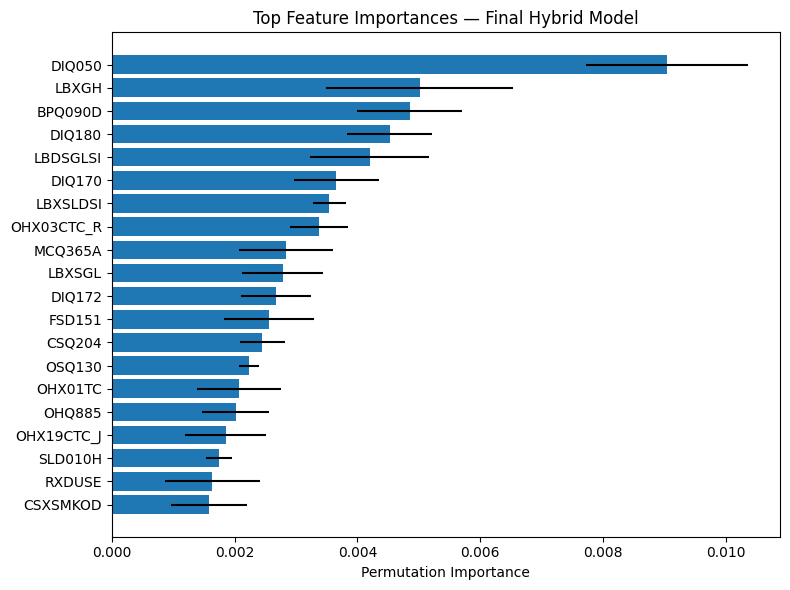

In [47]:
import matplotlib.pyplot as plt
import numpy as np

top_n = 20
order = np.argsort(perm.importances_mean)[::-1][:top_n]

plt.figure(figsize=(8, 6))
plt.barh(
    np.array(selected_feature_names)[order][::-1],
    perm.importances_mean[order][::-1],
    xerr=perm.importances_std[order][::-1]
)
plt.xlabel("Permutation Importance")
plt.title("Top Feature Importances — Final Hybrid Model")
plt.tight_layout()
plt.savefig("perm_importance.png", dpi=300)
plt.show()


In [43]:
joblib.dump(scaler_full, os.path.join(SAVE_DIR, "scaler_full.joblib"))
joblib.dump(idx_full, os.path.join(SAVE_DIR, f"idx_{SEL_METHOD}_topk.npy"))
joblib.dump(mlp_final, os.path.join(SAVE_DIR, f"mlp_hybrid_{SEL_METHOD}_topk.joblib"))
with open(os.path.join(SAVE_DIR, "selected_feature_names_final.txt"), "w") as f:
    f.write("\n".join(selected_feature_names))
print("Saved final artifacts to:", SAVE_DIR)

Saved final artifacts to: /content/drive/MyDrive/782_project/artifacts_fast_hybrid


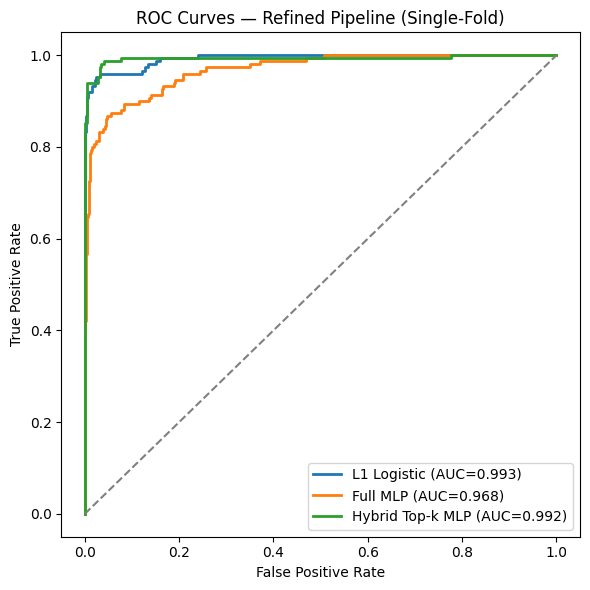

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_true = yt
prob_l1 = l1.predict_proba(Xt_s)[:,1]
prob_mlp = mlp.predict_proba(Xt_s)[:,1]
prob_hybrid = mlp_h.predict_proba(Xt_sel)[:,1]

fpr_l1, tpr_l1, _ = roc_curve(y_true, prob_l1)
auc_l1 = auc(fpr_l1, tpr_l1)

fpr_mlp, tpr_mlp, _ = roc_curve(y_true, prob_mlp)
auc_mlp = auc(fpr_mlp, tpr_mlp)

fpr_hyb, tpr_hyb, _ = roc_curve(y_true, prob_hybrid)
auc_hyb = auc(fpr_hyb, tpr_hyb)

plt.figure(figsize=(6,6))

plt.plot(fpr_l1, tpr_l1, label=f"L1 Logistic (AUC={auc_l1:.3f})", linewidth=2)
plt.plot(fpr_mlp, tpr_mlp, label=f"Full MLP (AUC={auc_mlp:.3f})", linewidth=2)
plt.plot(fpr_hyb, tpr_hyb, label=f"Hybrid Top-k MLP (AUC={auc_hyb:.3f})", linewidth=2)

plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Refined Pipeline (Single-Fold)")
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig("roc_refined.png", dpi=300)
plt.show()
